### In this notebook we shall look at some of the trrained models on different types of data to see whether there is some kind of structure int he latent space. UMAP will be needed in those cases where the dimensionality of the latent space is > 2. Use only TSVAE pretrained models as the should contain about the same information as AE and definitely the same as VAE.

In [1]:
using AlfvenDetectors
using Flux
using ValueHistories
using BSON
using PyPlot
using Dates
using PyCall
using GaussianMixtures
umap = pyimport("umap")

┌ Info: Recompiling stale cache file /home/vit/.julia/compiled/v1.1/AlfvenDetectors/VqnlF.ji for AlfvenDetectors [5e555b46-3391-11e9-1beb-e9498a8cd634]
└ @ Base loading.jl:1184


PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [2]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/data_sample/"
shots = readdir(datapath)
shotlist = joinpath.(datapath, shots)

16-element Array{String,1}:
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10000.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10001.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10002.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10003.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10004.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10005.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10006.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10007.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10008.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10370.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10514.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10800.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10866.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10870.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10893.h5"
 "/home/vit/vyzkum/alfven/c

In [3]:
measurement_type = "uprobe"
basemodelpath = "/home/vit/vyzkum/alfven/experiments/single_col/"
modelpath = joinpath(basemodelpath, measurement_type)
if measurement_type == "mscamp"
    readfun = AlfvenDetectors.readmscamp
elseif measurement_type == "mscphase"
    readfun = AlfvenDetectors.readnormmscphase
elseif measurement_type == "mscampphase"
    readfun = AlfvenDetectors.readmscampphase
elseif measurement_type == "uprobe"
    readfun = AlfvenDetectors.readnormlogupsd
end
coils = [12,13,14];
# also if using uprobe, only use a few shots
if measurement_type == "uprobe"
    shotlist = shotlist[9:12]
end

4-element Array{String,1}:
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10008.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10370.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10514.h5"
 "/home/vit/vyzkum/alfven/cdb_data/data_sample/Jldata10800.h5"

In [4]:
if measurement_type == "uprobe"
    rawdata = AlfvenDetectors.collect_signals(shotlist, readfun)
else
    rawdata = AlfvenDetectors.collect_signals(shotlist, readfun, coils)
end
data = rawdata;
M,N = size(data)

(513, 17800)

In [5]:
models = readdir(modelpath)

10-element Array{String,1}:
 "AE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:43.205.bson"                
 "AE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:09:44.836.bson"                 
 "AE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:43.403.bson"               
 "AE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:20:08.174.bson"                
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:44.195.bson"             
 "TSVAE_xdim-513_ldim-2_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:48:39.226.bson"              
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:42.886.bson"            
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:53:19.763.bson"             
 "VAE_xdim-513_ldim-2_nlayers-4_variant-scalar_batchsize-128_nepochs-1_2019-03-13T14:01:55.604.bson" 
 "VAE_xdim-513_ldim-32_nlayers-4_variant-scalar_batchs

### Now lets look at a particular model

In [6]:
modelname = "TSVAE"
ldim = 32
imodel = 1
submodels = filter(x->x[1:length(modelname)] == modelname, models)
submodels = filter(x->occursin("ldim-$ldim",x), submodels)
bsonpath = joinpath(modelpath,submodels[imodel])
submodels

2-element Array{String,1}:
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-10_2019-03-13T16:18:42.886.bson"
 "TSVAE_xdim-513_ldim-32_nlayers-4_batchsize-128_nepochs-1_2019-03-13T15:53:19.763.bson" 

In [7]:
showtime(time) = Dates.canonicalize(Dates.CompoundPeriod(Dates.Second(floor(Int,time))))

showtime (generic function with 1 method)

In [8]:
modeldata = BSON.load(bsonpath)
model = modeldata[:model]
history = modeldata[:history]
time = modeldata[:time]
println("Training time: $(showtime(time))" )

Training time: 1 hour, 22 minutes, 50 seconds


In [9]:
z = model.m1.encoder(data).data;
sz = model.m1.sampler(z);
z = z[1:ldim,:]
GC.gc()

In [10]:
z_umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)    
if ldim > 2
    #@time Matrix(umap_model.fit_transform((z[:,1:1000])')')
    @time z2D = Matrix(z_umap_model.fit_transform((z)')')
else
    z2D = z
end

 24.479526 seconds (2.20 M allocations: 107.115 MiB, 0.16% gc time)


2×17800 Array{Float32,2}:
 -7.32988  -7.97888  -8.37546  -8.33499  …   2.63518   2.62525   2.78631
 -4.90747  -4.90027  -4.24582  -4.35716     -1.7738   -6.03993  -6.01675

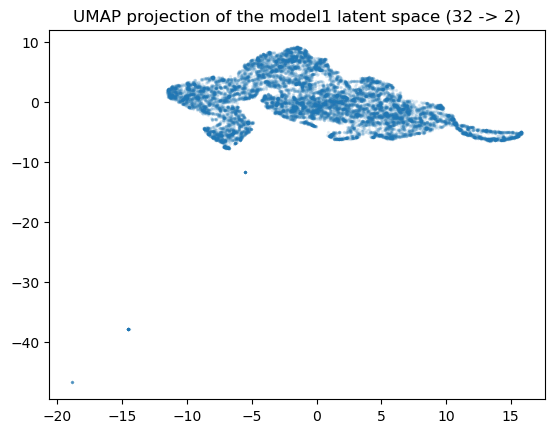

PyObject Text(0.5, 1.0, 'UMAP projection of the model1 latent space (32 -> 2)')

In [11]:
scatter(z2D[1,:], z2D[2,:], s= 2, alpha= 0.1)
title("UMAP projection of the model1 latent space ($ldim -> 2)")

#### Fit a GMM model to the 2D data

In [32]:
tz2D = Array(z2D')
kind = :full
gmm2D = GaussianMixtures.GMM(4, tz2D, kind=kind)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       8.631788e+04
      1       6.273287e+04      -2.358502e+04 |        4
      2       6.069850e+04      -2.034367e+03 |        4
      3       5.952538e+04      -1.173125e+03 |        4
      4       5.898283e+04      -5.425469e+02 |        4
      5       5.866781e+04      -3.150156e+02 |        4
      6       5.839189e+04      -2.759258e+02 |        4
      7       5.817532e+04      -2.165664e+02 |        4
      8       5.805261e+04      -1.227070e+02 |        4
      9       5.793595e+04      -1.166641e+02 |        4
     10       5.786999e+04      -6.595703e+01 |        4
     11       5.782856e+04      -4.142969e+01 |        3
     12       5.781095e+04      -1.760938e+01 |        4
     13       5.780406e+04      -6.890625e+00 |        4
     14       5.779653e+04      -7.531250e+00 |        4
     15       5.779438e+04      -2.152344e+00 |        

┌ Info: Initializing GMM, 4 Gaussians LinearAlgebra.diag covariance 2 dimensions using 17800 data points
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:77
┌ Info: K-means with 4000 data points using 18 iterations
│ 333.3 data points per parameter
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 4 Gaussians in 2 dimensions
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:242
┌ Info: iteration 1, average log likelihood -2.908710
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood -2.896300
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood -2.892374
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood 

GMM{Float32} with 4 components in 2 dimensions and full covariance
Mix 1: weight 0.257446
 mean: Float32[-7.61553, -0.854739]
 covariance: 2×2 Array{Float32,2}:
 4.47385   1.78931
 1.78931  24.9854 
Mix 2: weight 0.149695
 mean: Float32[9.43449, -3.54637]
 covariance: 2×2 Array{Float32,2}:
 13.6372   -5.27228
 -5.27228   3.28798
Mix 3: weight 0.450215
 mean: Float32[1.70806, -0.501926]
 covariance: 2×2 Array{Float32,2}:
 12.4475   -2.88689
 -2.88689   7.33055
Mix 4: weight 0.142645
 mean: Float32[-2.18939, 6.23535]
 covariance: 2×2 Array{Float32,2}:
 2.61877   0.292477
 0.292477  2.49718 


In [13]:
# for covariance isolines drawing
include("/home/vit/Dropbox/vyzkum/cisco/kod/lib/julia/BivariateNormal.jl")

Main.BivariateNormal

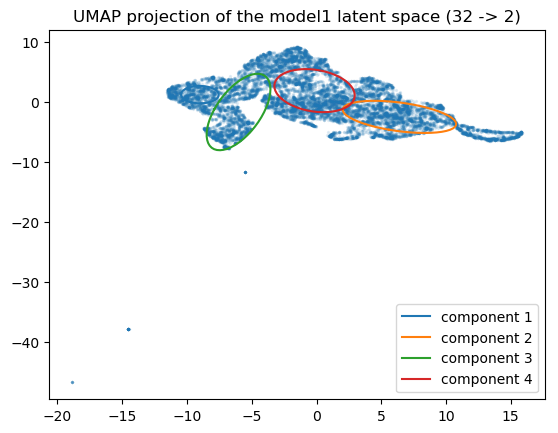

PyObject Text(0.5, 1.0, 'UMAP projection of the model1 latent space (32 -> 2)')

In [14]:
scatter(z2D[1,:], z2D[2,:], s= 2, alpha= 0.1)
covarmats = covars(gmm2D)
for i in 1:length(gmm2D.Σ)
    if kind == :diag
        Σ = [covarmats[i,1] 0; 0 covarmats[i,2]]
    else
        Σ = covarmats[i]
    end
    μ = gmm2D.μ[i,:]
    el = BivariateNormal.getEllipsis(Σ, μ, 50, 1.0);
    plot(el[:,1], el[:,2], label = "component $i")
end
legend()
title("UMAP projection of the model1 latent space ($ldim -> 2)")

### Try to select shots where there should be an Alfven mode and project them into the latent space.

In [15]:
function get_shot_data_code_and_projection(shot, coil, readfun, umap_model)
    f = joinpath(datapath, "Jldata$(shot).h5")
    if measurement_type == "uprobe"
        data = AlfvenDetectors.get_ft_signal(f, readfun)
    else
        data = AlfvenDetectors.get_ft_signals(f, readfun, coil)
    end
    z = (model.m1.encoder(data).data)[1:ldim,:]
    if ldim > 2
        z2D = Matrix(umap_model.transform(z')')
    else
        z2D = z
    end
    return data, z, z2D
end

get_shot_data_code_and_projection (generic function with 1 method)

In [16]:
shotlist = [(10000,12), (10893,14), (10370,12)]
alldata = map(x->get_shot_data_code_and_projection(x[1], x[2], readfun, z_umap_model),shotlist);

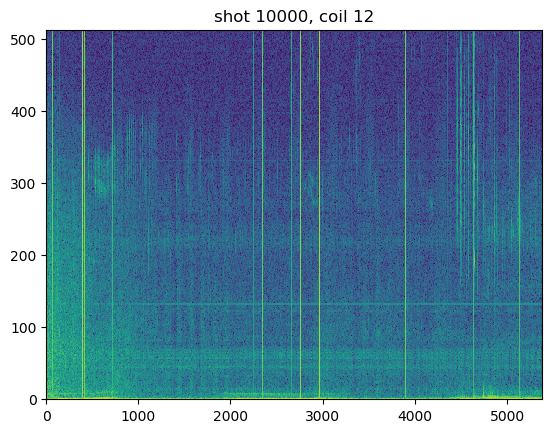

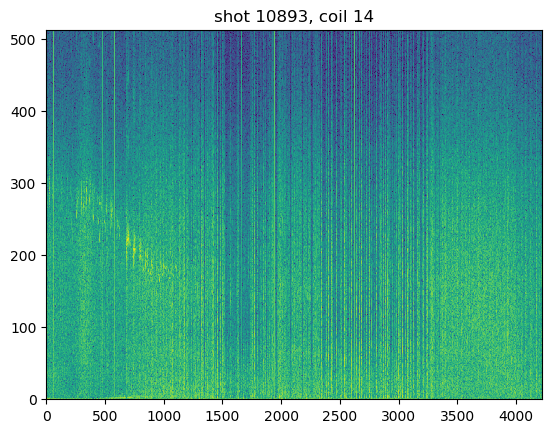

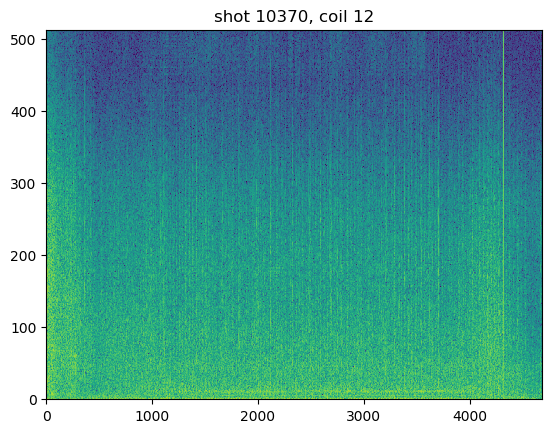

In [17]:
for (shotinfo,shotdata) in zip(shotlist,alldata)
    figure()
    title("shot $(shotinfo[1]), coil $(shotinfo[2])")
    pcolormesh(shotdata[1])
end

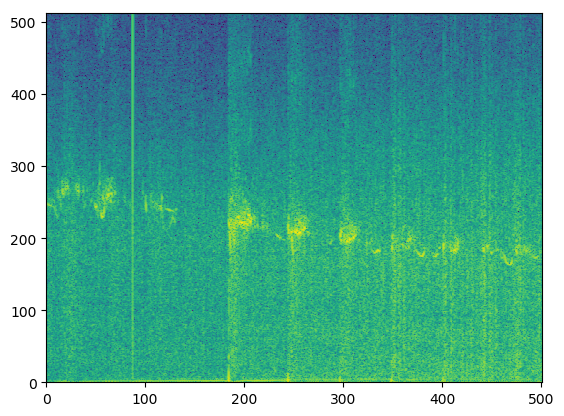

2×501 Array{Float32,2}:
 -5.6429   -5.38391  -5.78987  -5.80622  …  -7.19801  -7.00137  -6.75102
 -5.60671  -5.18693  -6.09038  -6.08198     -7.35102  -7.26257  -6.40341

In [18]:
inds = 500:1000
chirpx = alldata[2][1][:,inds]
pcolormesh(chirpx)
chirpz = (model.m1.encoder(chirpx).data)[1:ldim,:]
if ldim > 2
    chirpz2D = Matrix(z_umap_model.transform(chirpz')')
else
    chirpz2D = chirpz
end

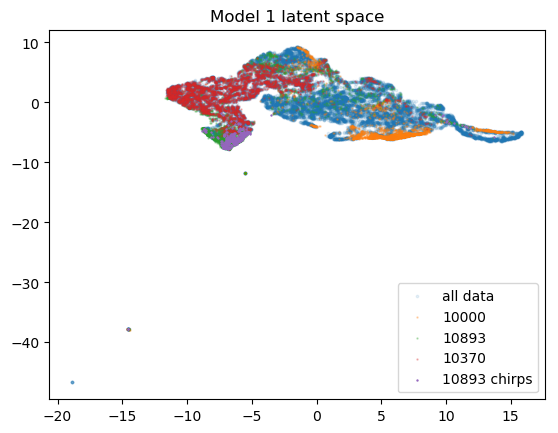

PyObject Text(0.5, 1.0, 'Model 1 latent space')

In [30]:
scatter(z2D[1,:], z2D[2,:], s=3, alpha= 0.1, label="all data")
for (shotinfo,shotdata) in zip(shotlist, alldata)
    scatter(shotdata[3][1,:],shotdata[3][2,:], label=shotinfo[1], s=0.5,alpha=0.3)
end
scatter(chirpz2D[1,:], chirpz2D[2,:], label = "10893 chirps", s=0.5,alpha=1)
legend()
title("Model 1 latent space")

In [20]:
tchirpz2D = Array(chirpz2D')
maxinds2D = map(x->x[2], argmax(llpg(gmm2D, tchirpz2D), dims = 2));

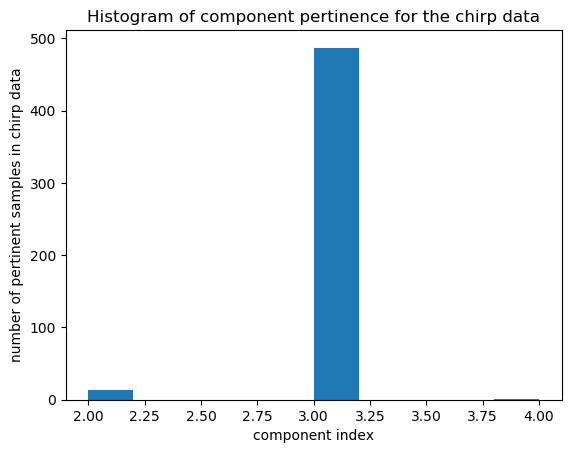

PyObject Text(24.00000000000002, 0.5, 'number of pertinent samples in chirp data')

In [21]:
plt.hist(maxinds2D)
title("Histogram of component pertinence for the chirp data")
xlabel("component index")
ylabel("number of pertinent samples in chirp data")

## Lets also try to fit GMM to the original latent space 

In [35]:
tz = Array(z')
kind = :full
@time gmmOrig = GaussianMixtures.GMM(6, tz, kind=kind)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.948788e+03
      1       2.317268e+03      -6.315205e+02 |        6
      2       2.246113e+03      -7.115430e+01 |        6
      3       2.189843e+03      -5.627051e+01 |        6
      4       2.135733e+03      -5.410938e+01 |        6
      5       2.085838e+03      -4.989526e+01 |        6
      6       2.044255e+03      -4.158362e+01 |        6
      7       2.021571e+03      -2.268347e+01 |        6


┌ Info: Initializing GMM, 6 Gaussians LinearAlgebra.diag covariance 32 dimensions using 17800 data points
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:77


      8       2.009570e+03      -1.200146e+01 |        6
      9       2.002298e+03      -7.271484e+00 |        6
     10       1.997732e+03      -4.565918e+00 |        6
     11       1.993951e+03      -3.781006e+00 |        6
     12       1.990692e+03      -3.258911e+00 |        6
     13       1.987831e+03      -2.861084e+00 |        6
     14       1.985651e+03      -2.179810e+00 |        6
     15       1.982674e+03      -2.977539e+00 |        6
     16       1.979709e+03      -2.964355e+00 |        6
     17       1.976590e+03      -3.119873e+00 |        6
     18       1.972085e+03      -4.504150e+00 |        6
     19       1.964040e+03      -8.045898e+00 |        6
     20       1.950143e+03      -1.389697e+01 |        6
     21       1.931098e+03      -1.904456e+01 |        6
     22       1.911718e+03      -1.937976e+01 |        6
     23       1.893043e+03      -1.867542e+01 |        6
     24       1.877854e+03      -1.518835e+01 |        6
     25       1.867122e+03     

┌ Info: K-means with 6000 data points using 49 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 6 Gaussians in 32 dimensions
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/train.jl:242
┌ Info: iteration 1, average log likelihood 3.843015
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood 3.919147
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood 3.948654
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood 3.973153
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 5, average log likelihood 3.987070
└ @ GaussianMixtures /home/vit/.julia/packages/

  0.994622 seconds (4.28 M allocations: 497.767 MiB, 7.82% gc time)


┌ Info: iteration 9, average log likelihood 4.013883
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: iteration 10, average log likelihood 4.016133
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71
┌ Info: EM with 17800 data points 10 iterations avll 4.016133
│ 5.3 data points per parameter
└ @ GaussianMixtures /home/vit/.julia/packages/GaussianMixtures/HTVx6/src/gmms.jl:71


GMM{Float32} with 6 components in 32 dimensions and full covariance
Mix 1: weight 0.153503
 mean: Float32[-0.0365566, 0.00392636, -0.0147788, 0.0153574, -0.315901, -0.0161706, -0.00791171, -0.0410865, -0.00128924, 0.0138677  …  0.00472057, 0.00589998, -0.0134357, 0.816581, -0.00531784, 0.0212116, 0.00499899, 0.00328434, 0.000639884, 0.00150313]
 covariance: 32×32 Array{Float32,2}:
  0.103684      0.000401481  -0.00412508   …   0.000947887  -0.000653703
  0.000401481   0.000116236  -8.548e-5        -7.02786e-6   -0.000107864
 -0.00412508   -8.548e-5      0.000360404     -4.197e-5      6.45222e-5 
 -0.00285391   -6.55545e-5    0.000153387     -2.55497e-5    8.03249e-5 
 -0.0210338    -0.00170648    0.00346849      -2.29398e-5    0.00180115 
 -7.99867e-5   -7.64773e-5    9.86969e-5   …   2.94508e-5    8.50016e-5 
  0.000806288   2.00172e-5   -3.34909e-6       2.3531e-5     2.15513e-5 
  0.00102643   -4.96172e-5   -4.93144e-5       3.2612e-5     6.75959e-5 
 -0.000802481  -2.41514e-5    9.

3 (1:1, 6:6)


In [36]:
tchirpz = Array(chirpz')
maxindsOrig = map(x->x[2], argmax(llpg(gmmOrig, tchirpz), dims = 2));

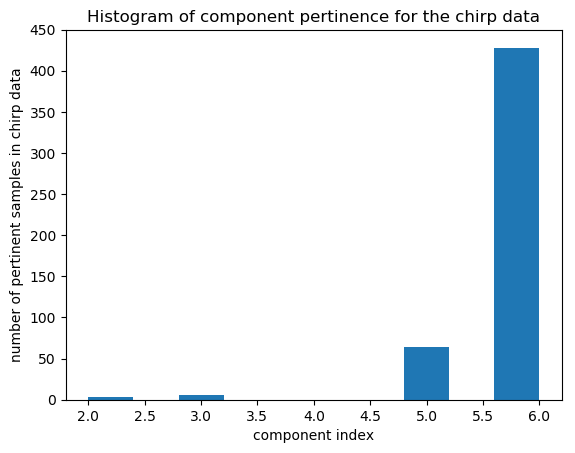

PyObject Text(24.00000000000002, 0.5, 'number of pertinent samples in chirp data')

In [37]:
plt.hist(maxindsOrig)
title("Histogram of component pertinence for the chirp data")
xlabel("component index")
ylabel("number of pertinent samples in chirp data")

Clearly, the chirping data are more likely to belong to one of the gaussian mixture model components thatn to the rest even in the original latent space dimension.

### What if we try to fit data from a whole shot?

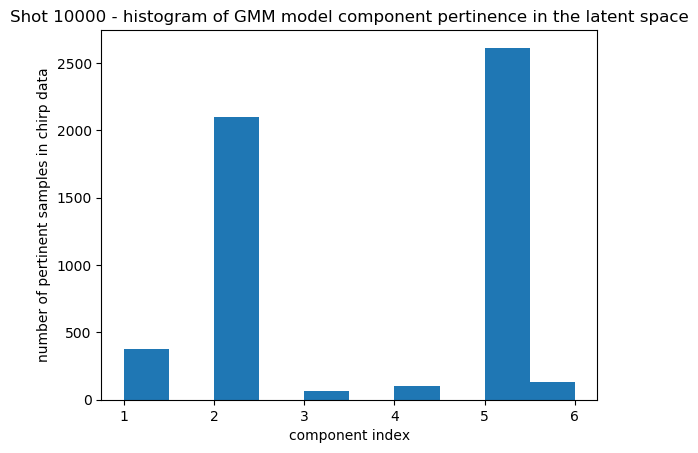

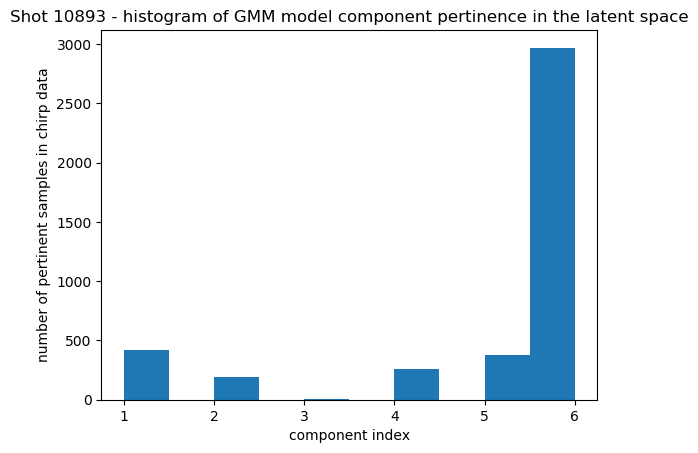

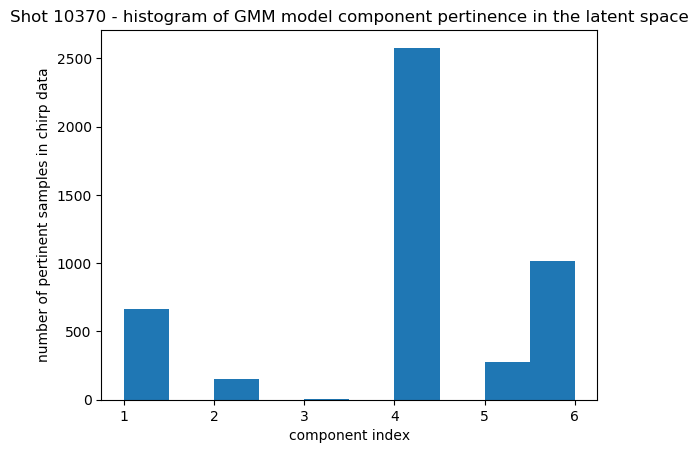

In [38]:
for (shotinfo,shotdata) in zip(shotlist, alldata)
    _tz = Array(shotdata[2]')
    maxinds = map(x->x[2], argmax(llpg(gmmOrig, _tz), dims = 2));
    figure()
    plt.hist(maxinds)
    title("Shot $(shotinfo[1]) - histogram of GMM model component pertinence in the latent space")
    xlabel("component index")
    ylabel("number of pertinent samples in chirp data")
end
